In [1]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
import time

cutoffDim = 9

In [109]:
def down(order, n, cutoff = 10):
    if order > n:
        return [0, 0]
    n_ = n - order
    coeff = np.prod(np.sqrt(np.arange(n, n - order, -1)))
    return [coeff, n_]

def up(order, n, cutoff = 10):
    n_ = n + order
    if n_ > cutoff:
        return [0, 0]
    coeff = np.prod(np.sqrt(np.arange(n + 1, n + 1 + order)))
    return [coeff, n_]

def photonNum(order, n, cutoff = 10):
    coeff = n ** order
    return [coeff, n]

def to_2d_ndarray(a):
    if isinstance(a,(np.ndarray)):
        return a
    else:
        return np.array([[a]])
    
def Sonin_vec(n, alpha, x):
    n = to_2d_ndarray(n)
    alpha = to_2d_ndarray(alpha)
    x = to_2d_ndarray(x)        
    N = np.max(n)
    a = special.factorial(n + alpha)
    S = np.zeros([N + 1, x.shape[0], x.shape[0], n.shape[0], n.shape[0]], dtype = "float64")
    for i in range(N + 1):
        if i == 0:
            S[0] = 1
        elif i == 1:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :]
            I_bar = np.logical_not(I).astype("float64")
            S[1] = (alpha + 1 - x) * I + I_bar
        else:
            I = np.where(n - i >= 0, 1, 0)
            I = I[np.newaxis, np.newaxis, :, :].astype("float64")
            I_bar = np.logical_not(I).astype(int)
            res = (2 * i - 1 + alpha - x) * S[i - 1] - (i + alpha - 1) * S[i - 2]
            S[i] = res / i * I + S[i -1] * I_bar
    return S[N]

def FockWignerElement_vec(xmat, pmat, l, m):
    A = np.max(np.dstack([l, m]), axis=2)
    B = np.abs(l - m)
    C = np.min(np.dstack([l, m]), axis=2)
    xmat = xmat[:, :, np.newaxis, np.newaxis]
    pmat = pmat[:, :, np.newaxis, np.newaxis]
    R = xmat**2 + pmat**2
    X = xmat + np.sign(l-m) * 1j * pmat
    W = 2 * (-1)**C * np.sqrt(2**(B) * special.factorial(C) / special.factorial(A)) * X**(B) * np.exp(-R)
    S = Sonin_vec(C, B, 2 * R)
    return W * S

## Multi mode化

prepare multi mode Fock state

In [110]:
modeNum = 3
cutoffDim = 9
def vacuumState(modeNum, cutoffDim):
    fockState = np.zeros([modeNum, cutoffDim + 1]) + 0j
    fockState[:, 0] = 1
    return fockState
vacuumState(modeNum, cutoffDim)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j]])

In [111]:
def singleGate_preProcess(fockState, mode):
    fockState = np.swapaxes(fockState, mode, modeNum - 1)
    return fockState.reshape(-1, cutoffDim + 1)

def singleGate_postProcess(fockState, mode):
    fockState = fockState.reshape([cutoffDim + 1] * modeNum)
    return np.swapaxes(fockState, mode, modeNum - 1)

def exp_annihiration(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for j in range(fockState.shape[-1]):
        for i in range(cutoff + 1):
            tmp =  down(i, j) # order, n
            state[np.int(tmp[1])] += tmp[0] * fockState[j] / special.factorial([i]) * alpha ** i
    return state

def exp_creation(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for j in range(fockState.shape[-1]):
        for i in range(cutoff + 1):
            tmp =  up(i, j, cutoffDim)
            state[np.int(tmp[1])] += tmp[0] * fockState[j] / special.factorial([i]) * alpha ** i
    return state

def exp_photonNum(fockState, alpha, cutoff):
    state = np.zeros(fockState.shape) + 0j
    for j in range(fockState.shape[-1]):
        for i in range(cutoff + 1):
            tmp =  photonNum(i, j, cutoffDim)
            state[np.int(tmp[1])] += tmp[0] * fockState[j] / special.factorial([i]) * alpha ** i
    return state

def exp_twoMode(state1, state2, alpha, cutoff):
    state1_ = np.zeros(state1.shape) + 0j
    state2_ = np.zeros(state2.shape) + 0j
    for j in range(state1.shape[-1]):
        for i in range(cutoff + 1):
            tmp1 = down(i, j, cutoffDim)
            tmp2 = up(i, j, cutoffDim)
            state1_[np.int(tmp1[1])] += tmp1[0] * state1[j] / special.factorial([i]) * alpha ** i
            state2_[np.int(tmp2[1])] += tmp2[0] * state2[j] / special.factorial([i]) * alpha ** i
    return [state1_, state2_]

In [112]:
def reduceState(fockState, mode):
    ax = [i for i in range(modeNum) if i != mode]
    state = fockState.sum(axis = tuple(ax))
    return  state / np.sum(np.abs(state)**2)
reduceState(fockState, 2)

(0.4725017055412994+0.0205017443244588j)

In [113]:
def displacement(fockState, mode, alpha, cutoff):
    state = fockState[mode]
    state = exp_annihiration(state, -np.conj(alpha), cutoff)
    state = exp_creation(state, alpha, cutoff)
    state = state * np.exp(-np.abs(alpha)**2 / 2)
    fockState[mode] = state
    return fockState

### 試してみる

In [114]:
alpha = - 1 + 1j
mode = 2
fockState = vacuumState(modeNum, cutoffDim)
state = displacement(fockState, mode, alpha, cutoffDim)
print(state)

[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.36787944+0.j         -0.36787944+0.36787944j  0.        -0.5202601j
   0.30037231+0.30037231j -0.30037231+0.j          0.13433058-0.13433058j
   0.        +0.10968046j -0.04145532-0.04145532j  0.02931334+0.j
  -0.00977111+0.00977111j]]


In [115]:
def FockWigner_vec(xmat, pmat, fockState, mode, tol=1e-10):
    state = fockState[mode]
    dim = len(state)
    rho = np.outer(np.conj(state), state)
    grid = np.indices([dim, dim])
    W = FockWignerElement_vec(xmat, pmat, grid[0], grid[1])
    W = rho * W
    W = np.sum(np.sum(W, axis = -1), axis = -1)
    if np.max(np.imag(W)) < tol:
        W = np.real(W)
    else:
        raise ValueError("Wigner plot has imaginary value.")
    return W

0.2901649475097656


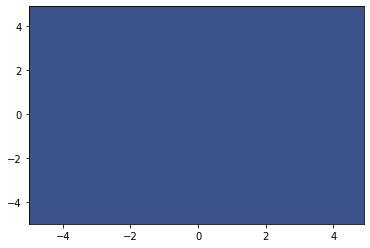

In [173]:
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W = FockWigner_vec(xx, pp, state, 2)

h = plt.contourf(x, p, W)
t = time.time() - start
print(t)

### Beam Splitter

In [123]:
def BSgate(fockState, mode1, mode2, theta, cutoff):
    fockState_ = np.copy(fockState)
    a = np.copy(fockState[mode1])
    b = np.copy(fockState[mode2])
    b_ = exp_photonNum(b, -0.5 * theta**2, cutoff)
    a_ = exp_photonNum(a, 0.5 * theta**2, cutoff)
    [a_, b_] = exp_twoMode(a_, b_, -theta, cutoff)
    [b_, a_] = exp_twoMode(b_, a_, theta, cutoff)
    fockState_[mode1] = a_
    fockState_[mode2] = b_
    return fockState_

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
[[ 1.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j
   0.00000000e+00+0.j]
 [ 1.00000000e+00+0.j  7.85398163e-01+0.j  4.36179012e-01+0.j
   1.97785304e-01+0.j  7.76701072e-02+0.j  2.72809057e-02+0.j
   8.74728023e-03+0.j  2.59665291e-03+0.j  7.21039056e-04+0.j
   1.88767583e-04+0.j]
 [ 5.39641484e-01+0.j -4.23833458e-01+0.j  2.35380078e-01+0.j
  -1.06734393e-01+0.j  4.19085551e-02+0.j -1.47402955e-02+0.j
   4.67352163e-03+0.j -1.48892559e-03+0.j  2.76265916e-04+0.j
  -1.88767583e-04+0.j]]
0.18443703651428223


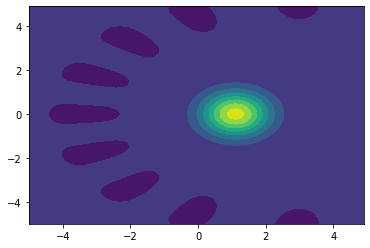

In [140]:
alpha = - 1 + 1j
mode = 2
fockState = vacuumState(modeNum, cutoffDim)
#fockState = displacement(fockState, mode, alpha, cutoffDim)
#state2 = displacement(fockState, mode, alpha / 2, cutoffDim)
print(fockState)

afterState = BSgate(fockState, 1, 2, np.pi / 4, cutoffDim)
print(afterState)
x = np.arange(-5, 5, 0.1)
p = np.arange(-5, 5, 0.1)
m = len(x)
xx, pp = np.meshgrid(x, p)
xi_array = np.dstack((pp, xx))
start = time.time()
        
W = FockWigner_vec(xx, pp, afterState, 1)

h = plt.contourf(x, p, W)
t = time.time() - start
print(t)

7.78800783e-01+0.00000000e+00j -3.89400392e-01+3.89400392e-01j
   0.00000000e+00-2.75347657e-01j  7.94860221e-02+7.94860221e-02j
  -3.97430110e-02+0.00000000e+00j  8.88680743e-03-8.88680743e-03j
   0.00000000e+00+3.62802394e-03j -6.85632079e-04-6.85632079e-04j
   2.42407546e-04+0.00000000e+00j -4.04012577e-05+4.04012577e-05j]]
0.19344210624694824

In [159]:
cutoff = 9
a = np.zeros(cutoff + 1)
b = np.zeros(cutoff + 1)
a[0] = 1
b[0] = 1
b_ = exp_photonNum(b, -0.5 * theta**2, cutoff)
print(b_)
[a_, b_] = exp_twoMode(a, b, -theta, cutoff)
print(a_)
print(b_)
[b_, a_] = exp_twoMode(b_, a_, theta, cutoff)
print(a_)
print(b_)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
[ 1.00000000e+00+0.j -7.85398163e-01+0.j  4.36179012e-01+0.j
 -1.97785304e-01+0.j  7.76701072e-02+0.j -2.72809057e-02+0.j
  8.74728023e-03+0.j -2.59665291e-03+0.j  7.21039056e-04+0.j
 -1.88767583e-04+0.j]
[1.00000000e+00+0.j 7.85398163e-01+0.j 4.36179012e-01+0.j
 1.97785304e-01+0.j 7.76701072e-02+0.j 2.72809057e-02+0.j
 8.74728023e-03+0.j 2.59665291e-03+0.j 7.21039056e-04+0.j
 1.88767583e-04+0.j]
[ 5.39641484e-01+0.j -4.23833458e-01+0.j  2.35380078e-01+0.j
 -1.06734393e-01+0.j  4.19085551e-02+0.j -1.47402955e-02+0.j
  4.67352163e-03+0.j -1.48892559e-03+0.j  2.76265916e-04+0.j
 -1.88767583e-04+0.j]


In [164]:
cutoff = 9
a = np.zeros(cutoff + 1)
a[0] = 1
state = exp_annihiration(a, 1, cutoff)
print(state)
state = exp_creation(a, 1, cutoff)
state

[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]


array([1.        +0.j, 1.        +0.j, 0.70710678+0.j, 0.40824829+0.j,
       0.20412415+0.j, 0.09128709+0.j, 0.0372678 +0.j, 0.0140859 +0.j,
       0.00498012+0.j, 0.00166004+0.j])